# Imports

In [128]:
import pandas as pd
import seaborn as sns
sns.set_style('dark')
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import gensim
from gensim.utils import simple_preprocess

import pickle

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.filterwarnings('ignore',category=FutureWarning)

## Load `df`

In [129]:
with open('data/second_gensim.pickle', 'rb') as f:
    df = pickle.load(f)

In [130]:
df

,medical_specialty,transcription,second_gensim_clean
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...","[mode, atrial, enlargement, atrial, diameter, ..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,"[ventricular, cavity, size, wall, thickness, a..."
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","[echocardiogram, multiple, view, heart, great,..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....","[description, cardiac, chamber, size, ventricu..."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...","[study, mild, aortic, stenosis, widely, calcif..."
...,...,...,...
3709,Cardiovascular / Pulmonary,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...","[indication, chest, pain, type, test, adenosin..."
3710,Cardiovascular / Pulmonary,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...","[chief, complaint, chest, pain, present, illne..."
3711,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , The patient is a...","[present, illness, year, old, woman, follow, a..."
3712,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...","[present, illness, mr, year, old, gentleman, m..."


In [131]:
df['second_gensim_clean'][1]

['ventricular',
 'cavity',
 'size',
 'wall',
 'thickness',
 'appear',
 'wall',
 'motion',
 'ventricular',
 'systolic',
 'function',
 'appear',
 'hyperdynamic',
 'estimate',
 'ejection',
 'fraction',
 'near',
 'cavity',
 'obliteration',
 'see',
 'also',
 'appear',
 'increase',
 'ventricular',
 'outflow',
 'tract',
 'gradient',
 'mid',
 'cavity',
 'level',
 'consistent',
 'hyperdynamic',
 'ventricular',
 'systolic',
 'function',
 'abnormal',
 'ventricular',
 'relaxation',
 'pattern',
 'see',
 'elevate',
 'atrial',
 'pressure',
 'see',
 'doppler',
 'examination',
 'atrium',
 'appear',
 'mildly',
 'dilate',
 'atrium',
 'ventricle',
 'appear',
 'aortic',
 'root',
 'appear',
 'aortic',
 'valve',
 'appear',
 'calcify',
 'mild',
 'aortic',
 'valve',
 'stenosis',
 'calculate',
 'aortic',
 'valve',
 'area',
 'cm',
 'square',
 'maximum',
 'instantaneous',
 'gradient',
 'mean',
 'gradient',
 'mm',
 'mitral',
 'annular',
 'calcification',
 'extend',
 'leaflet',
 'supportive',
 'structure',
 'thicke

# Top 25 Words Overall

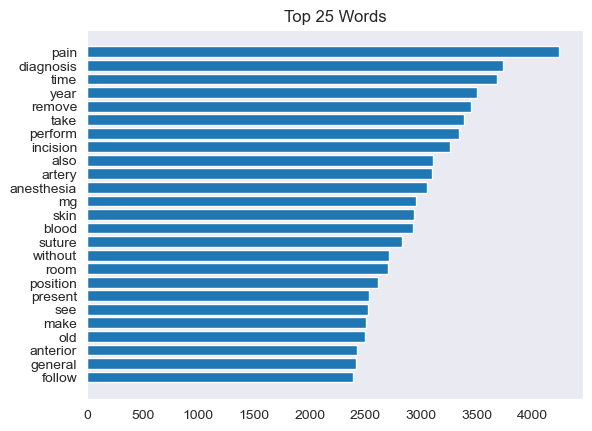

In [132]:
word_count = {}
for doc in df['second_gensim_clean']:
    for word in doc:
        if word not in word_count:
            word_count[word]=1
        if word in word_count:
            word_count[word]+=1
word_count = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True))
word_count = list(word_count.items())[:25]
keys = [item[0] for item in word_count]
values = [item[1] for item in word_count]
fig,ax = plt.subplots()
ax.barh(keys, values)
ax.invert_yaxis()
ax.set_title('Top 25 Words');

In [133]:
word_count

[('pain', 4244),
 ('diagnosis', 3741),
 ('time', 3682),
 ('year', 3503),
 ('remove', 3448),
 ('take', 3385),
 ('perform', 3343),
 ('incision', 3265),
 ('also', 3106),
 ('artery', 3102),
 ('anesthesia', 3052),
 ('mg', 2957),
 ('skin', 2934),
 ('blood', 2933),
 ('suture', 2831),
 ('without', 2714),
 ('room', 2707),
 ('position', 2614),
 ('present', 2535),
 ('see', 2526),
 ('make', 2510),
 ('old', 2500),
 ('anterior', 2426),
 ('general', 2418),
 ('follow', 2393)]

# Top 25 words by Specialty

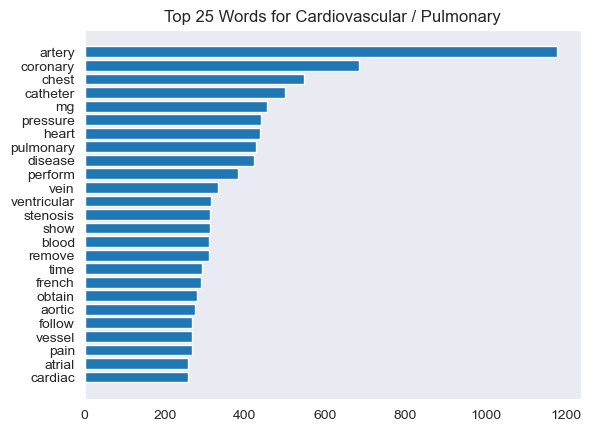

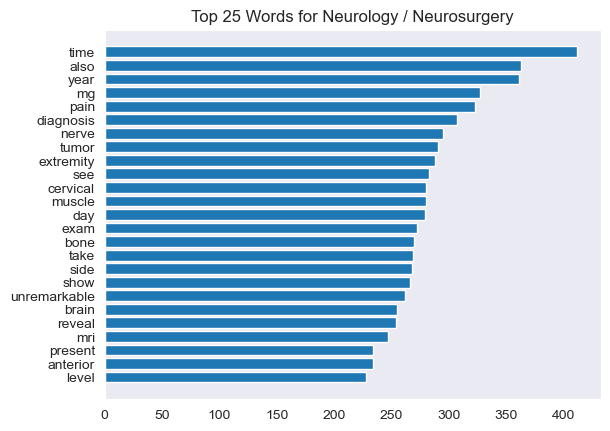

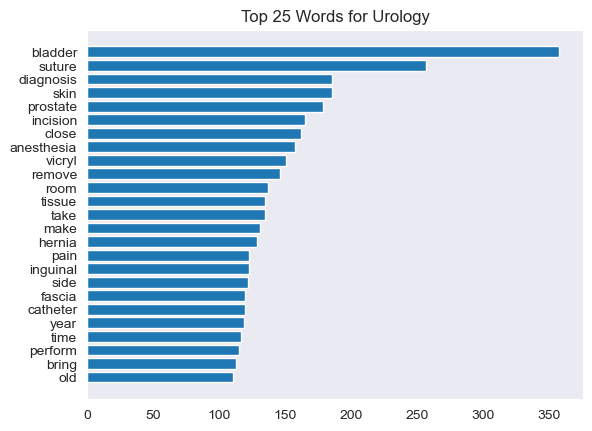

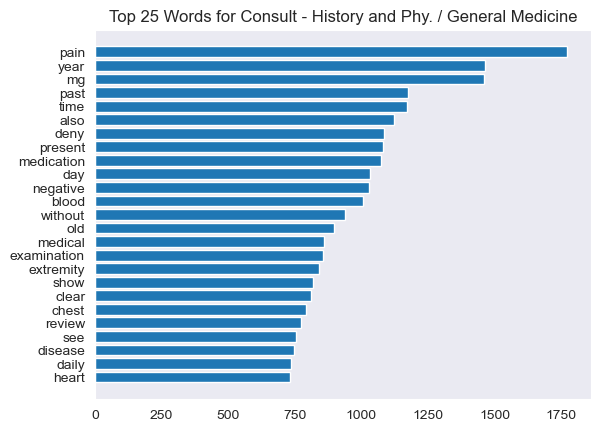

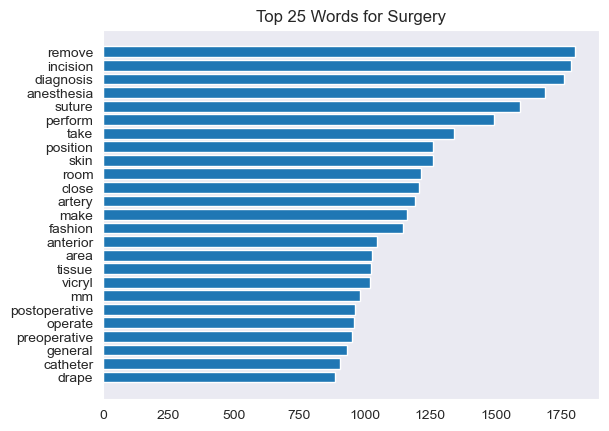

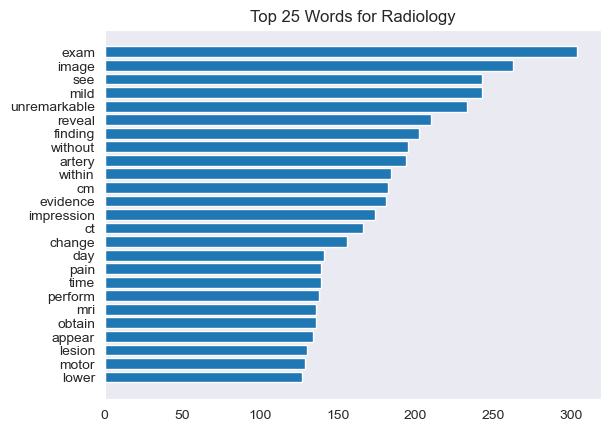

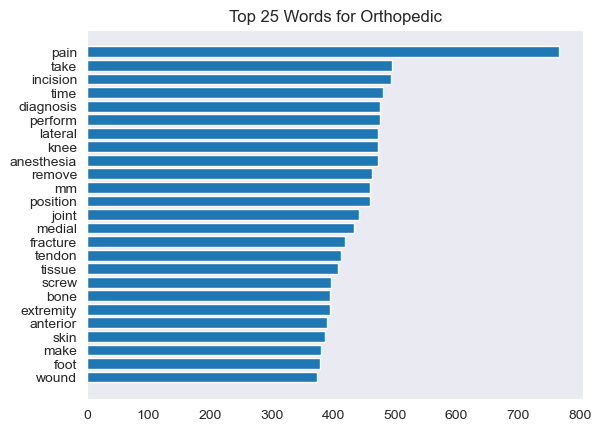

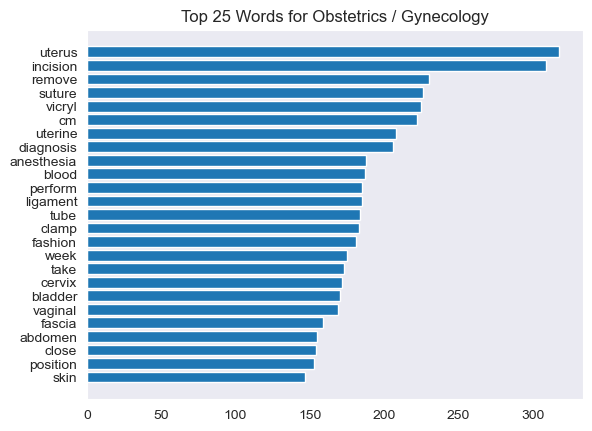

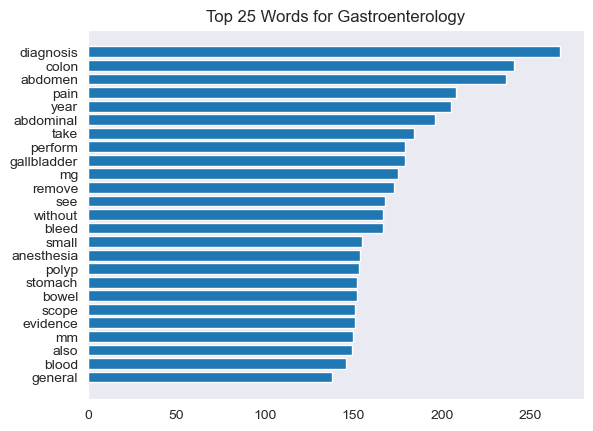

In [134]:
def count_by_spec(df,spec):
    df_spec = df[df['medical_specialty']==spec]
    word_count = {}
    for doc in df_spec['second_gensim_clean']:
        for word in doc:
            if word not in word_count:
                word_count[word]=1
            if word in word_count:
                word_count[word]+=1
    word_count = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True))
    word_count = list(word_count.items())[:25]
    keys = [item[0] for item in word_count]
    values = [item[1] for item in word_count]
    fig,ax = plt.subplots(1,1)
    ax.barh(keys, values)
    ax.invert_yaxis()
    ax.set_title(f'Top 25 Words for {spec}')
    
for spec in df['medical_specialty'].unique():
    count_by_spec(df,spec)

# Function for obtaining ngrams

In [135]:
def num_ngrams(dictionary):
    words = list(dictionary.token2id.keys())
    ngrams = [word for word in words if '_' in word]
    print('Number of ngrams: ', len(ngrams))
    
def observe_ngrams(df,count=int,thresh=int):
    bigram_phrases = gensim.models.phrases.Phrases(df['second_gensim_clean'], min_count=count, threshold=thresh)
    trigram_phrases = gensim.models.phrases.Phrases(bigram_phrases[df['second_gensim_clean']],min_count=count,threshold=thresh)

    bigrams = gensim.models.phrases.Phraser(bigram_phrases)
    trigrams = gensim.models.phrases.Phraser(trigram_phrases)
    
    ngrammed = df['second_gensim_clean'].apply(lambda x: trigrams[bigrams[x]])
    
    ngram_dict = gensim.corpora.Dictionary(ngrammed)
    print('Length of dictionary: ', len(ngram_dict))
    num_ngrams(ngram_dict)
    return ngrammed, ngram_dict

# Seeing if any change in word freqs with ngrams

Length of dictionary:  17462
Number of ngrams:  2123


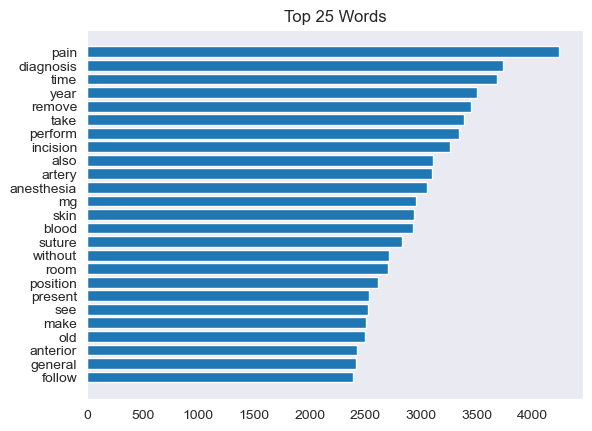

In [136]:
df['ngrammed'], ngram_dict = observe_ngrams(df,count=25,thresh=10)

word_count = {}
for doc in df['ngrammed']:
    for word in doc:
        if word not in word_count:
            word_count[word]=1
        if word in word_count:
            word_count[word]+=1
word_count = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True))
fig,ax = plt.subplots(1,1)
ax.barh(keys, values)
ax.invert_yaxis()
ax.set_title('Top 25 Words');

# Topic Model Weights by Topic

In [137]:
vec = TfidfVectorizer(min_df=5,max_df=0.95)
ngrammed_vecd = vec.fit_transform(df['ngrammed'].apply(lambda x: ' '.join(x)))

topic_model = NMF(n_components = 9,random_state=42)
topic_mat = topic_model.fit_transform(ngrammed_vecd)

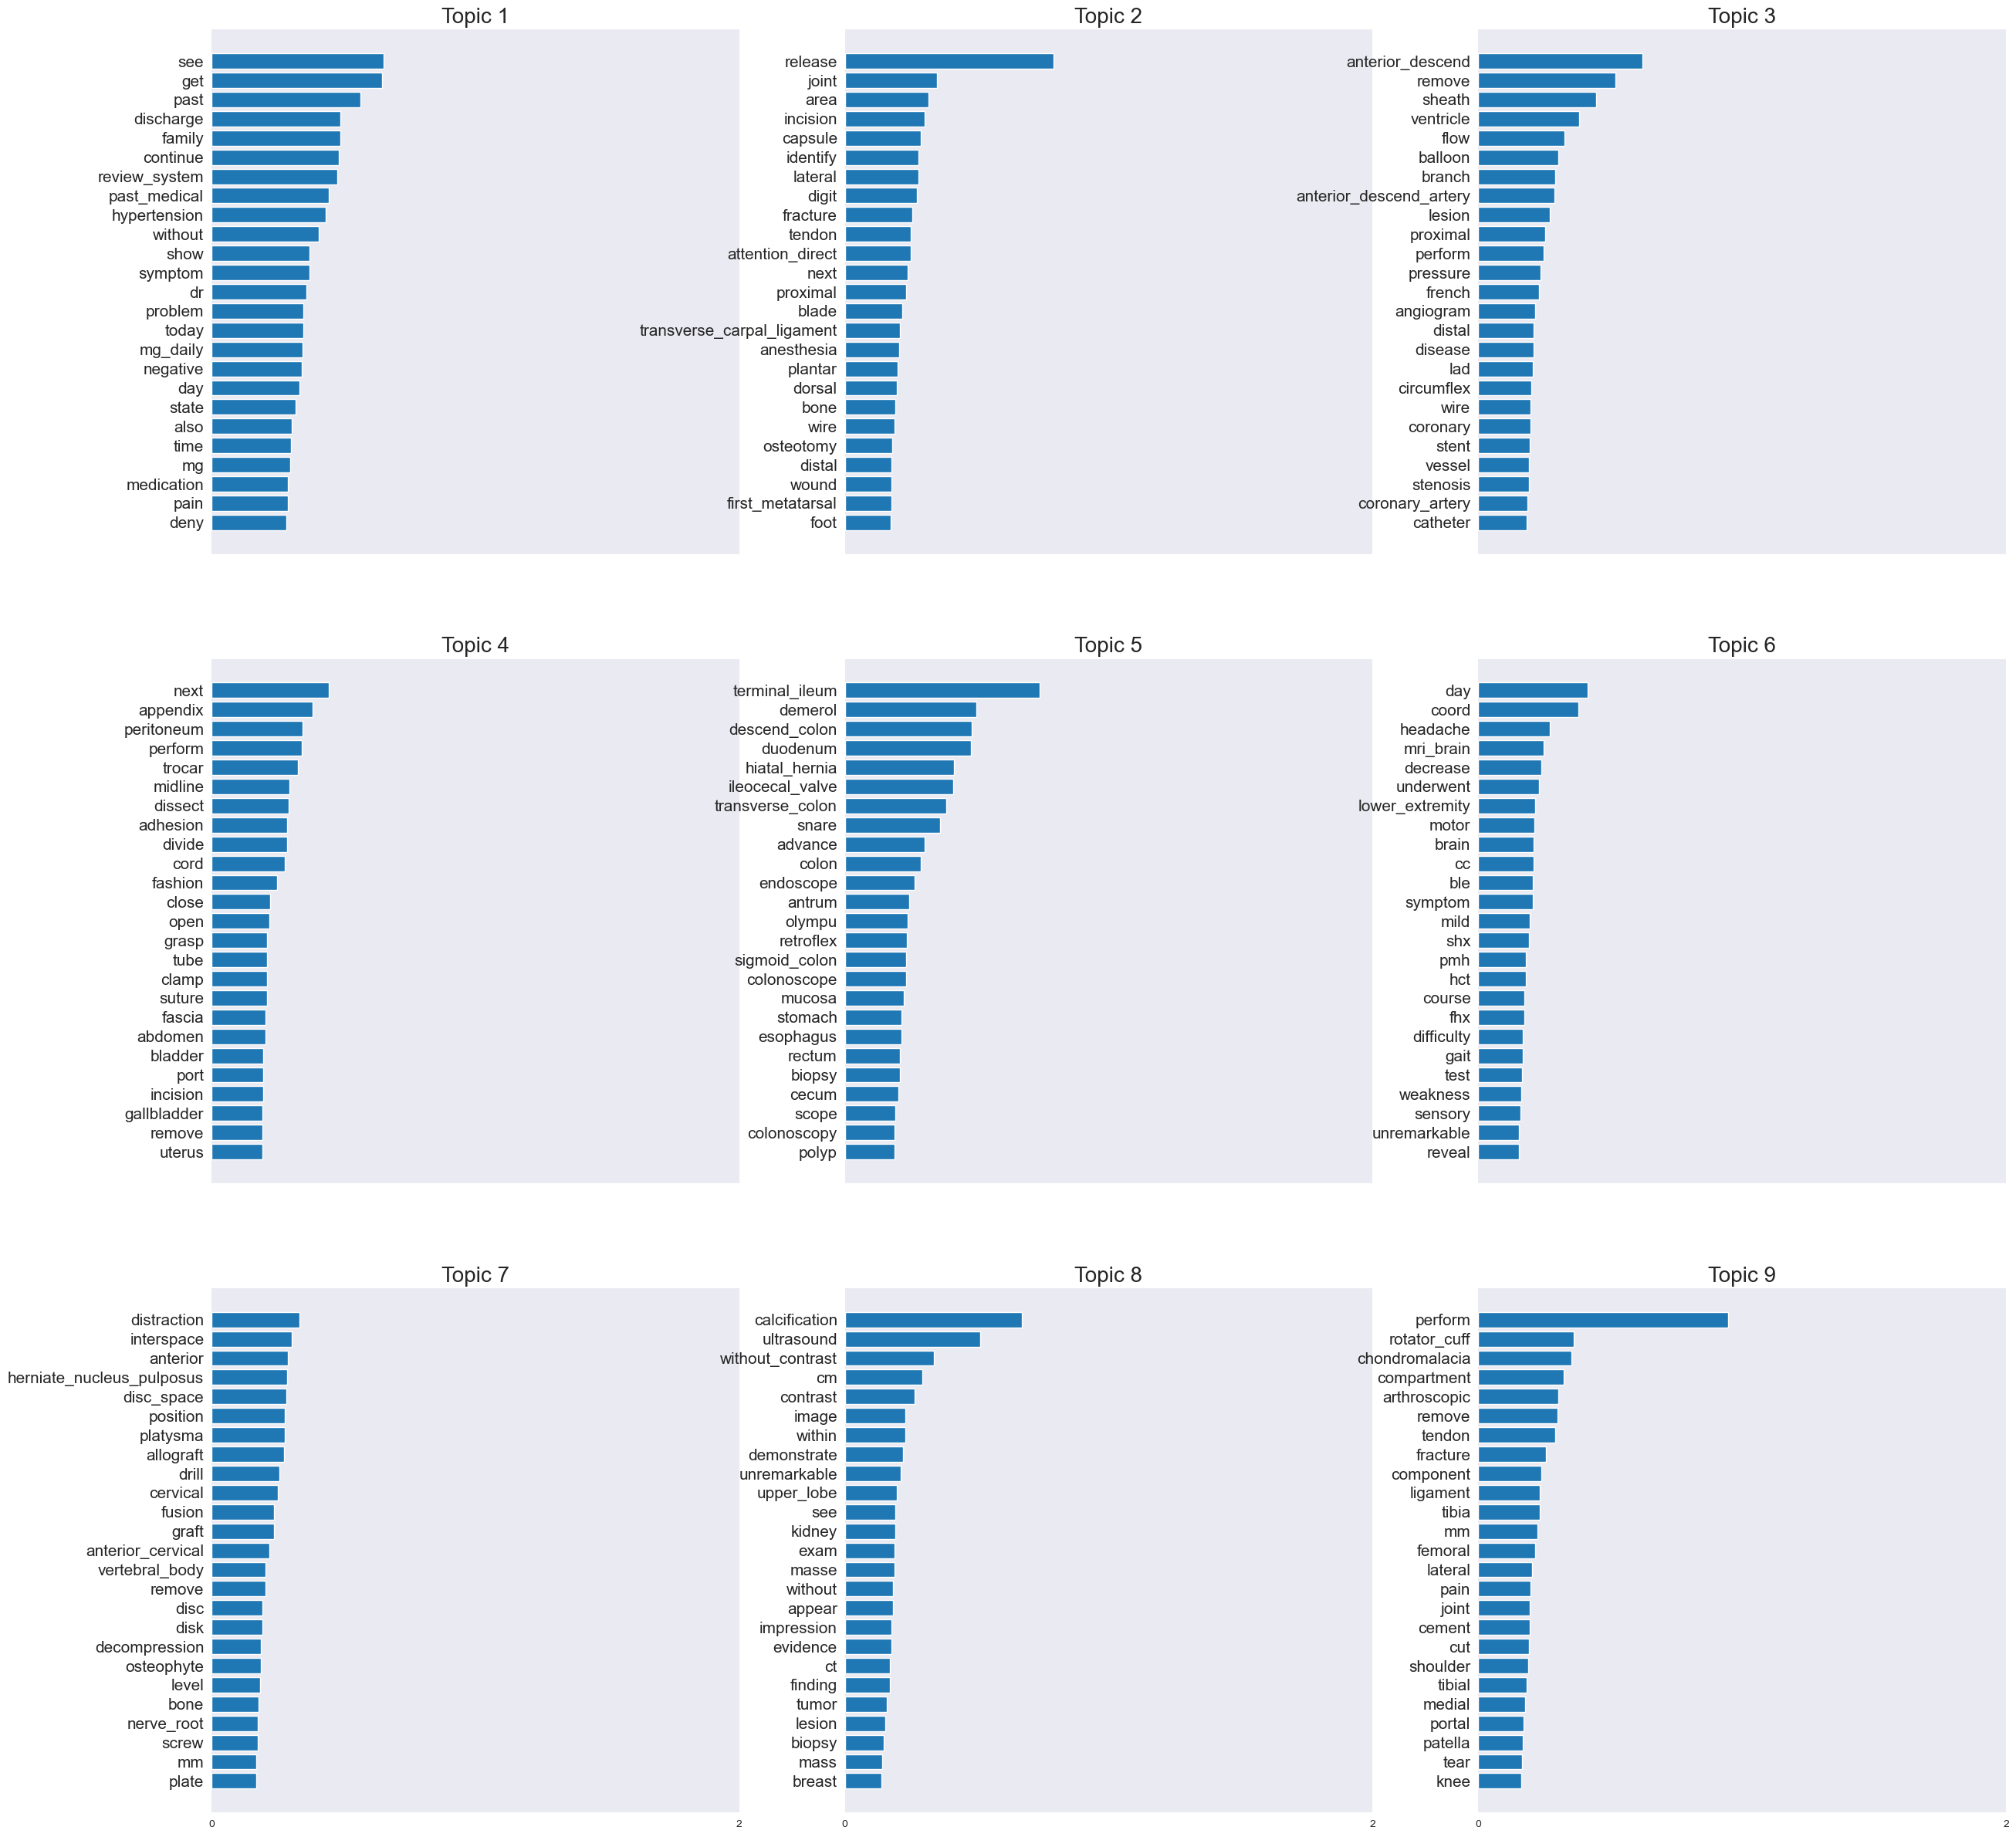

In [138]:
fig,axes = plt.subplots(3,3,figsize=(30,30),sharex=True)
for i, axis in enumerate(axes.flatten()):
    topic = topic_model.components_[i]
    top_words = [vec.get_feature_names()[j] for j in topic.argsort()[-25:]]
    top_features_ind = topic.argsort()[: -25 - 1 : -1]
    weight = topic[top_features_ind]
    ax=axis
    ax.barh(top_words,weight)
    ax.invert_yaxis()
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(f'Topic {i+1}',fontsize=20)
    for i in "top right left".split():
            ax.spines[i].set_visible(False)
    
    ax.set_xlim([0, 2])
    ax.set_xticks([0, 2])

# pyLDAvis of NMF

In [139]:
vis = pyLDAvis.sklearn.prepare(topic_model,ngrammed_vecd,vec)
vis

/Users/evan/miniforge3/envs/tf_env/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/evan/miniforge3/envs/tf_env/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/evan/miniforge3/envs/tf_env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/evan/miniforge3/envs/tf_env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/evan/miniforge3/envs/tf_env/lib/python3.10/site-packages/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.226734  0.081809       1        1  21.265505
3      0.136088 -0.086516       2        1  15.323371
7     -0.109119 -0.080085       3        1  11.838852
5     -0.237830  0.186518       4        1  11.031164
2     -0.039591 -0.127735       5        1   9.579747
6      0.166672  0.055778       6        1   9.509585
1      0.204393  0.071664       7        1   8.707413
8      0.162686  0.142325       8        1   6.513760
4     -0.056565 -0.243757       9        1   6.230604, topic_info=         Term       Freq      Total Category  logprob  loglift
4692     knee  50.000000  50.000000  Default  30.0000  30.0000
1063   breast  56.000000  56.000000  Default  29.0000  29.0000
6680    polyp  35.000000  35.000000  Default  28.0000  28.0000
3406     foot  47.000000  47.000000  Default  27.0000  27.0000
912    biopsy  49.000000  49.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
3552  gastric   8.308237  10.021538   Topic9  -5.5752   2.5882
912    biopsy  19.631354  49.630706   Topic9  -4.7153   1.8482
182   advance  10.586791  21.936770   Topic9  -5.3329   2.0471
231       air   8.301391  12.863098   Topic9  -5.5760   2.3378
1588       cm   8.289623  41.890336   Topic9  -5.5775   1.1556

[760 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
8         1  0.243718             abdomen
8         2  0.626705             abdomen
8         3  0.104451             abdomen
9         2  0.990818  abdomen_insufflate
10        2  0.124564      abdomen_pelvis
...     ...       ...                 ...
9715      7  0.503178               wound
9715      8  0.062897               wound
9746      1  0.910479                 xyz
9774      3  1.000902                  yy
9797      1  0.919782              zyrtec

[1302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 8, 6, 3, 7, 2, 9, 5])